In [1]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Data(Dataset):
    def __init__(self, N_SAMPLES=1000, noise_std=0.15, train=True):
        a = np.matrix([-1, 1, 2, 1, 1, -3, 1]).T
        self.x = np.matrix(np.random.rand(N_SAMPLES, 2))
        self.f = np.array(a[0] + (self.x) * a[1:3] + np.multiply(self.x[:, 0], self.x[:, 1]) * a[4] + np.multiply(self.x, self.x) * a[5:7]).flatten()
        self.a = a

        self.y = np.zeros(N_SAMPLES)
        self.y[self.f > 0] = 1
        self.y = torch.from_numpy(self.y).type(torch.LongTensor)
        self.x = torch.from_numpy(self.x).type(torch.FloatTensor)
        self.x = self.x + noise_std * torch.randn(self.x.size())
        self.f = torch.from_numpy(self.f)
        self.a = a
        if train == True:
            torch.manual_seed(1)
            self.x = self.x + noise_std * torch.randn(self.x.size())
            torch.manual_seed(0)


    def __getitem__(self, index):
        return self.x[index], self.y[index]


    def __len__(self):
        return self.len

In [3]:
dataset = Data()

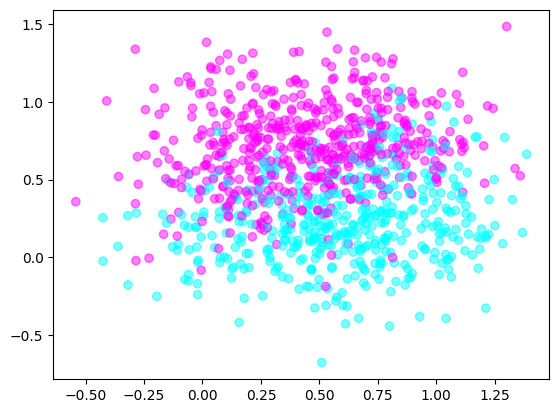

In [4]:
plt.scatter(dataset.x[:,0].detach().numpy(), dataset.x[:,1].detach().numpy(), c=dataset.y.detach().numpy(), alpha=0.5, cmap='cool')

In [5]:
class Net(nn.Module):
  def __init__(self, input_size, l1, l2, output_size, p=0):
    super(Net, self).__init__()
    self.linear1 = nn.Linear(input_size, l1)
    self.linear2 = nn.Linear(l1, l2)
    self.linear3 = nn.Linear(l2, output_size)
    self.dropout = nn.Dropout(p)
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.linear1(x)
    x = self.dropout(x)
    x = self.relu(x)
    x = self.linear2(x)
    x = self.dropout(x)
    x = self.relu(x)
    x = self.linear3(x)
    return x

In [6]:
validation_set = Data(train = False)

In [7]:
model = Net(2, 256, 128, 2)
model_drop = Net(2, 256, 128, 2, p=0.5)

In [8]:
optimizer_ofit = optim.Adam(model.parameters(), lr = 0.01)
optimizer_drop = optim.Adam(model.parameters(), lr = 0.01)
criterion = nn.CrossEntropyLoss()

In [9]:
epochs = 1000
LOSS = {}
LOSS['training data no dropout'] = []
LOSS['validation data no dropout'] = []
LOSS['training data dropout'] = []
LOSS['validation data dropout'] = []

def train_model(epochs):

    for epoch in range(epochs):

        yhat = model(dataset.x)
        yhat_drop = model_drop(dataset.x)
        loss = criterion(yhat, dataset.y)
        loss_drop = criterion(yhat_drop, dataset.y)

        LOSS['training data no dropout'].append(loss.item())
        LOSS['validation data no dropout'].append(criterion(model(validation_set.x), validation_set.y).item())
        LOSS['training data dropout'].append(loss_drop.item())
        model_drop.eval()
        LOSS['validation data dropout'].append(criterion(model_drop(validation_set.x), validation_set.y).item())
        model_drop.train()

        optimizer_ofit.zero_grad()
        optimizer_drop.zero_grad()
        loss.backward()
        loss_drop.backward()
        optimizer_ofit.step()
        optimizer_drop.step()

train_model(epochs)

In [10]:
n_iters = np.array([i for i in range(epochs)])

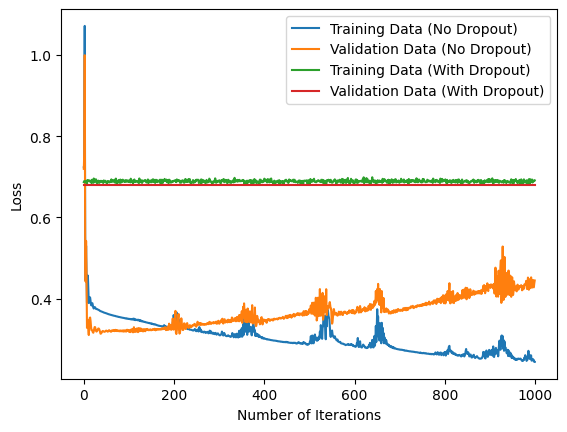

In [11]:
n_iters = range(len(LOSS['training data no dropout']))

plt.plot(n_iters, LOSS['training data no dropout'], label='Training Data (No Dropout)')

plt.plot(n_iters, LOSS['validation data no dropout'], label='Validation Data (No Dropout)')

plt.plot(n_iters, LOSS['training data dropout'], label='Training Data (With Dropout)')

plt.plot(n_iters, LOSS['validation data dropout'], label='Validation Data (With Dropout)')

plt.xlabel('Number of Iterations')
plt.ylabel('Loss')
plt.legend()

plt.show()
